In [1]:
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

Random Seed:  999


In [11]:
# Root directory for dataset
dataroot = "/Users/tachamae/Downloads/Thesis/GAN_separate_datasets/Separate_datasets/Melanoma"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 64

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 90

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

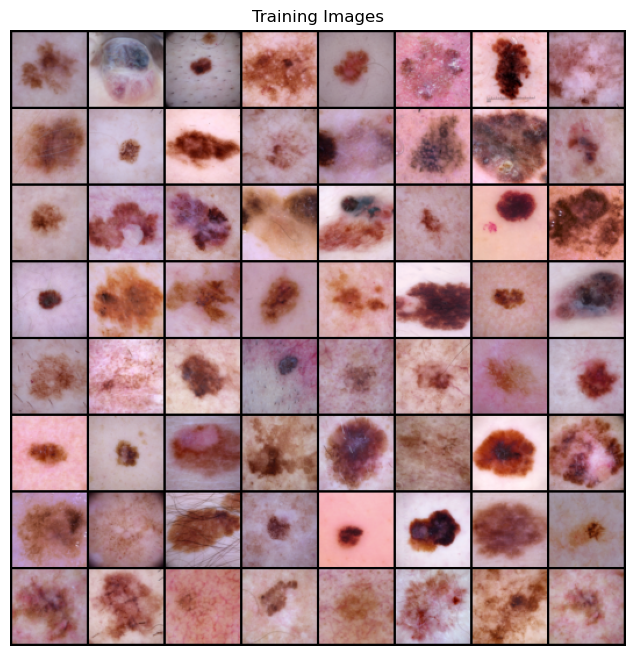

In [3]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

In [4]:
len(dataset)

1113

In [5]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [6]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. ``(ngf) x 32 x 32``
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. ``(nc) x 64 x 64``
        )

    def forward(self, input):
        return self.main(input)

In [7]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [8]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is ``(nc) x 64 x 64``
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 32 x 32``
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 16 x 16``
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*8) x 4 x 4``
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [9]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
# like this: ``to mean=0, stdev=0.2``.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [10]:
# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    
    if epoch % 5 == 0:
        print("CHECKPOINT: Saving the models.")
        # Save the entire model to the specified file
        torch.save(netG, "/Users/tachamae/Downloads/Thesis/GAN_separate_datasets/GAN_melanoma/Generator_melanoma_checkpoint.pth")
        torch.save(netD, "/Users/tachamae/Downloads/Thesis/GAN_separate_datasets/GAN_melanoma/Discriminator_melanoma_checkpoint.pth")
    
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 100 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
CHECKPOINT: Saving the models.
[0/200][0/18]	Loss_D: 1.5360	Loss_G: 6.1477	D(x): 0.6583	D(G(z)): 0.5891 / 0.0030
[1/200][0/18]	Loss_D: 0.1250	Loss_G: 9.2954	D(x): 0.9552	D(G(z)): 0.0353 / 0.0002
[2/200][0/18]	Loss_D: 2.8546	Loss_G: 24.0590	D(x): 0.9776	D(G(z)): 0.9164 / 0.0000
[3/200][0/18]	Loss_D: 1.1615	Loss_G: 22.7168	D(x): 0.5625	D(G(z)): 0.0000 / 0.0000
[4/200][0/18]	Loss_D: 0.7303	Loss_G: 15.8549	D(x): 0.9907	D(G(z)): 0.4621 / 0.0000
CHECKPOINT: Saving the models.
[5/200][0/18]	Loss_D: 0.6660	Loss_G: 3.2064	D(x): 0.6470	D(G(z)): 0.0536 / 0.0621
[6/200][0/18]	Loss_D: 0.2495	Loss_G: 4.7130	D(x): 0.8302	D(G(z)): 0.0307 / 0.0109
[7/200][0/18]	Loss_D: 0.7898	Loss_G: 5.3974	D(x): 0.5533	D(G(z)): 0.0006 / 0.0085
[8/200][0/18]	Loss_D: 1.4206	Loss_G: 15.9006	D(x): 0.9959	D(G(z)): 0.7147 / 0.0000
[9/200][0/18]	Loss_D: 2.4658	Loss_G: 14.5309	D(x): 0.9980	D(G(z)): 0.8673 / 0.0000
CHECKPOINT: Saving the models.
[10/200][0/18]	Loss_D: 0.1337	Loss_G: 4.4531	D(x): 0.932

[92/200][0/18]	Loss_D: 0.6807	Loss_G: 2.5148	D(x): 0.7713	D(G(z)): 0.2982 / 0.1014
[93/200][0/18]	Loss_D: 0.6421	Loss_G: 3.4166	D(x): 0.8325	D(G(z)): 0.3308 / 0.0487
[94/200][0/18]	Loss_D: 0.9588	Loss_G: 3.4638	D(x): 0.8437	D(G(z)): 0.4976 / 0.0412
CHECKPOINT: Saving the models.
[95/200][0/18]	Loss_D: 0.6280	Loss_G: 3.1092	D(x): 0.7626	D(G(z)): 0.2622 / 0.0662
[96/200][0/18]	Loss_D: 0.8219	Loss_G: 2.5193	D(x): 0.6572	D(G(z)): 0.2830 / 0.1073
[97/200][0/18]	Loss_D: 0.5998	Loss_G: 2.6261	D(x): 0.6930	D(G(z)): 0.1584 / 0.1274
[98/200][0/18]	Loss_D: 0.5261	Loss_G: 3.1863	D(x): 0.9357	D(G(z)): 0.3304 / 0.0594
[99/200][0/18]	Loss_D: 0.8183	Loss_G: 2.1312	D(x): 0.5521	D(G(z)): 0.1357 / 0.1608
CHECKPOINT: Saving the models.
[100/200][0/18]	Loss_D: 0.7240	Loss_G: 5.0768	D(x): 0.9233	D(G(z)): 0.4332 / 0.0108
[101/200][0/18]	Loss_D: 1.0339	Loss_G: 2.3224	D(x): 0.5998	D(G(z)): 0.2967 / 0.1390
[102/200][0/18]	Loss_D: 0.7736	Loss_G: 2.8160	D(x): 0.7103	D(G(z)): 0.2975 / 0.0817
[103/200][0/18]	Loss_D

# Continue training from a checkpoint

In [14]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

netD = torch.load("/Users/tachamae/Downloads/Thesis/GAN_separate_datasets/GAN_melanoma/Discriminator_melanoma_checkpoint_epoch110.pth")
netG = torch.load("/Users/tachamae/Downloads/Thesis/GAN_separate_datasets/GAN_melanoma/Generator_melanoma_checkpoint_epoch110.pth")

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    
    if epoch % 5 == 0:
        print("CHECKPOINT: Saving the models.")
        # Save the entire model to the specified file
        torch.save(netG, "/Users/tachamae/Downloads/Thesis/GAN_separate_datasets/GAN_melanoma/Generator_melanoma_checkpoint.pth")
        torch.save(netD, "/Users/tachamae/Downloads/Thesis/GAN_separate_datasets/GAN_melanoma/Discriminator_melanoma_checkpoint.pth")
    
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 100 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
CHECKPOINT: Saving the models.
[0/90][0/18]	Loss_D: 0.6433	Loss_G: 1.6027	D(x): 0.7543	D(G(z)): 0.2648 / 0.2648
[1/90][0/18]	Loss_D: 0.5644	Loss_G: 1.7180	D(x): 0.7839	D(G(z)): 0.2323 / 0.2323
[2/90][0/18]	Loss_D: 0.4924	Loss_G: 1.6331	D(x): 0.8387	D(G(z)): 0.2482 / 0.2482
[3/90][0/18]	Loss_D: 0.5185	Loss_G: 1.8354	D(x): 0.7602	D(G(z)): 0.1873 / 0.1873
[4/90][0/18]	Loss_D: 0.5216	Loss_G: 1.6137	D(x): 0.8341	D(G(z)): 0.2570 / 0.2570
CHECKPOINT: Saving the models.
[5/90][0/18]	Loss_D: 0.4267	Loss_G: 1.6632	D(x): 0.8753	D(G(z)): 0.2354 / 0.2354
[6/90][0/18]	Loss_D: 0.4934	Loss_G: 1.7681	D(x): 0.8238	D(G(z)): 0.2301 / 0.2301
[7/90][0/18]	Loss_D: 0.5818	Loss_G: 1.5330	D(x): 0.7871	D(G(z)): 0.2598 / 0.2598
[8/90][0/18]	Loss_D: 0.6561	Loss_G: 1.6289	D(x): 0.7283	D(G(z)): 0.2505 / 0.2505
[9/90][0/18]	Loss_D: 0.6753	Loss_G: 1.5630	D(x): 0.7271	D(G(z)): 0.2581 / 0.2581
CHECKPOINT: Saving the models.
[10/90][0/18]	Loss_D: 0.5408	Loss_G: 1.6192	D(x): 0.7997	D(G(z)): 0.245

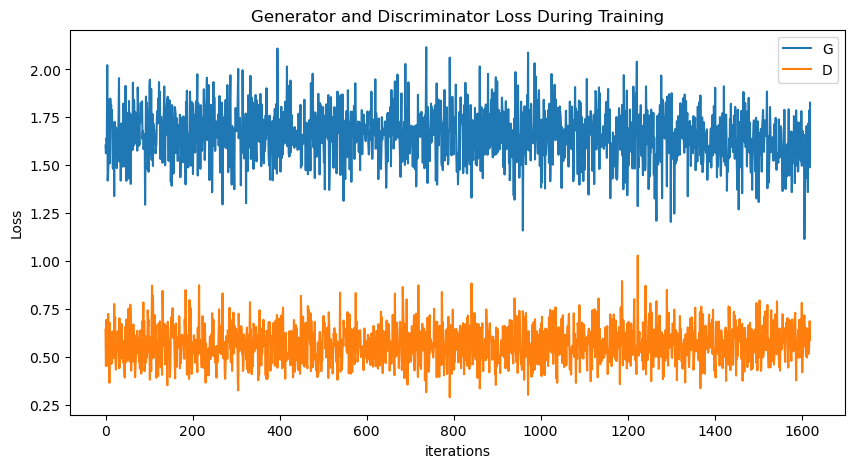

In [15]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

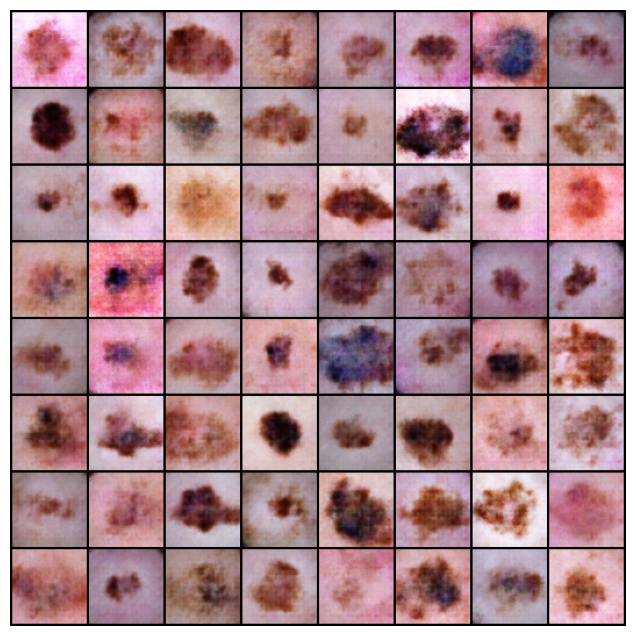

In [16]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

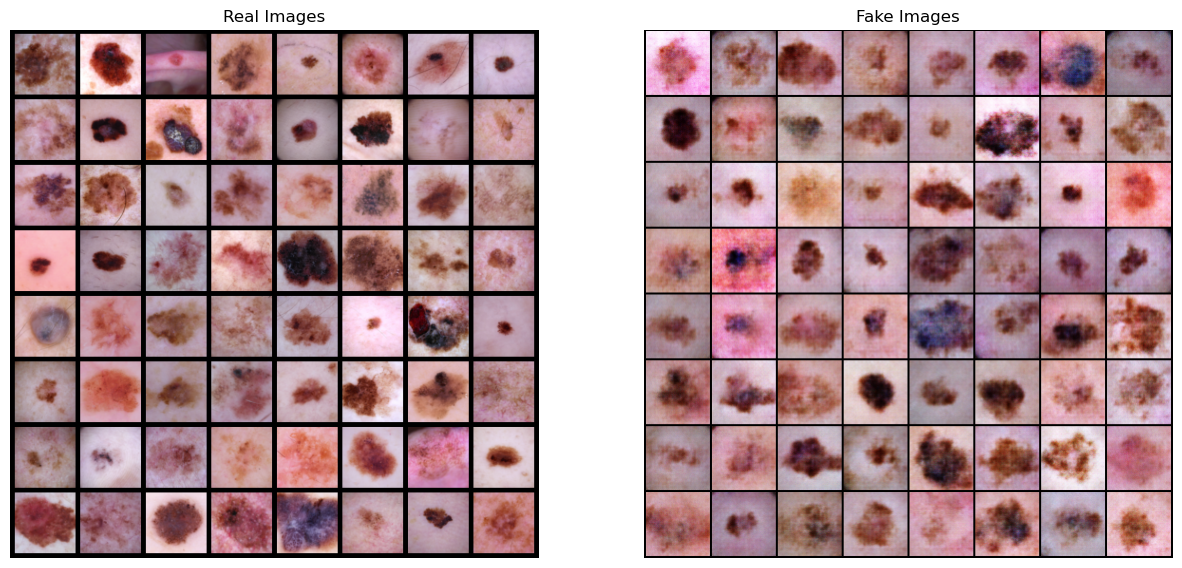

In [17]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [19]:
# Save the entire model to the specified file
torch.save(netG, "/Users/tachamae/Downloads/Thesis/GAN_separate_datasets/GAN_melanoma/Generator_melanoma_checkpoint_epoch200.pth")
torch.save(netD, "/Users/tachamae/Downloads/Thesis/GAN_separate_datasets/GAN_melanoma/Discriminator_melanoma_checkpoint_epoch200.pth")

In [21]:
import torch
import torchvision.utils as vutils
import os

# Define the device (GPU or CPU) to run the generator
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Load the generator model from the saved file
# generator = torch.load('/content/drive/MyDrive/celeba/skin/Generator.pth', map_location=device)
generator = netG

# Set the model to evaluation mode
generator.eval()

# Define the number of images to generate
num_images = 5592

# Define the directory to save the generated images
save_dir = '/Users/tachamae/Downloads/Thesis/GAN_separate_datasets/GAN_melanoma/generated_images'

# Create the directory if it does not exist
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Generate new images
for i in range(num_images):
    # Generate random noise
    noise = torch.randn(1, nz, 1, 1, device=device)

    # Generate an image from the noise
    with torch.no_grad():
        generated_image = generator(noise).detach().cpu()

    # Normalize the pixel values of the generated image to the range [0, 1]
    generated_image = (generated_image - generated_image.min()) / (generated_image.max() - generated_image.min())

    # Save the generated image to the specified directory
    image_path = os.path.join(save_dir, f'image_{i+1}.png')
    vutils.save_image(generated_image, image_path)

print(f'{num_images} images generated and saved to {save_dir} successfully.')

5592 images generated and saved to /Users/tachamae/Downloads/Thesis/GAN_separate_datasets/GAN_melanoma/generated_images successfully.
